In [8]:
import sys
import glob
sys.path.append("../")
import CryoAsicAnalysis
import CryoAsicFile
import yaml
import pickle
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from cluster import HierarchicalClustering
plt.style.use("~/evanstyle.mplstyle")

In [2]:
datapath = "/p/lustre2/nexouser/data/StanfordData/ChargeModule/LXe_Run1_Processed_Data/Gamma_Data_Post_Surgery_7_15_24/"
pfiles = glob.glob(datapath+"*24pt*.p")

config_filepath = "../config/analysisconfig.yml"


In [6]:


#combine the dataframes from many files. 
full_df = None
for f in pfiles:
    if("combined" in f):
        continue
    temp_df = pickle.load(open(f, "rb"))[0]
    if(full_df is None):
        full_df = temp_df
    else:
        full_df = pd.concat([full_df, temp_df], ignore_index=True)

pickle.dump([full_df], open("/p/lustre2/nexouser/data/StanfordData/angelico/combined_6g_24pt_1000us.p", "wb"))


In [3]:
#use the pickle file made above,
#or choose one file
ca = CryoAsicAnalysis.CryoAsicAnalysis("/p/lustre2/nexouser/data/StanfordData/angelico/combined_6g_24pt_1000us.p", config_filepath)
ca.baseline_subtract()

loading the waveform dataframe from  /p/lustre2/nexouser/data/StanfordData/angelico/combined_6g_24pt_1000us.p
Done loading


In [ ]:
#some debugging validating the pulse finder is working
nevts = ca.nevents_total
time_masks = [[0, 50], [980, 1050]]

for i in range(nevts):
    all_pulses = ca.find_pulses_in_event(i, n_sigma=6)
    print(all_pulses)
    #random sampling of pulses
    some_pulses = np.random.choice(all_pulses, 20)
    fig, (ax, axi) = plt.subplots(nrows = 2)
    #ca.plot_strips_waveforms_separated(i, ax=[ax, axi], sep=0, show=False)
    for pulse in some_pulses:
        if(pulse["amplitude"] < 0): continue
        mask = False
        for m in time_masks:
            if(m[0] < pulse["time"] < m[1]):
                mask = True
                break
        
        if(mask): continue 
        
        ch = pulse["channel"]
        wave = ca.get_wave(i, ch)
        buffer = int(5/ca.dT) #N microseconds, in samples
        wave_range = []
        if(len(pulse["index"]) == 1):
            wave_range = [pulse["index"][0]-buffer, pulse["index"][0]+buffer]
            pulse_length = 1
        else:
            wave_range = [pulse["index"][0]-buffer, pulse["index"][-1]+buffer]
            pulse_length = pulse["index"][1] - pulse["index"][0] #samples

        if(wave_range[0] < 0): wave_range[0] = 0
        if(wave_range[1] > len(wave)): wave_range[1] = len(wave)


        small_wave = wave[wave_range[0]:wave_range[1]]
        times = ca.times[wave_range[0]:wave_range[1]]

        ax.plot(times, small_wave, linewidth=3, color='r')


    
    ax.set_xlabel("time [us]")
    ax.set_ylabel("signal [ADC counts]")
    axi.set_xlabel("time [us]")
    axi.set_ylabel("cumulative signal [ADC counts]")
#    ax.set_ylim([-50, 50])
#    axi.set_ylim([-50, 50])
    plt.show()
    if(i == 10):
        break




0


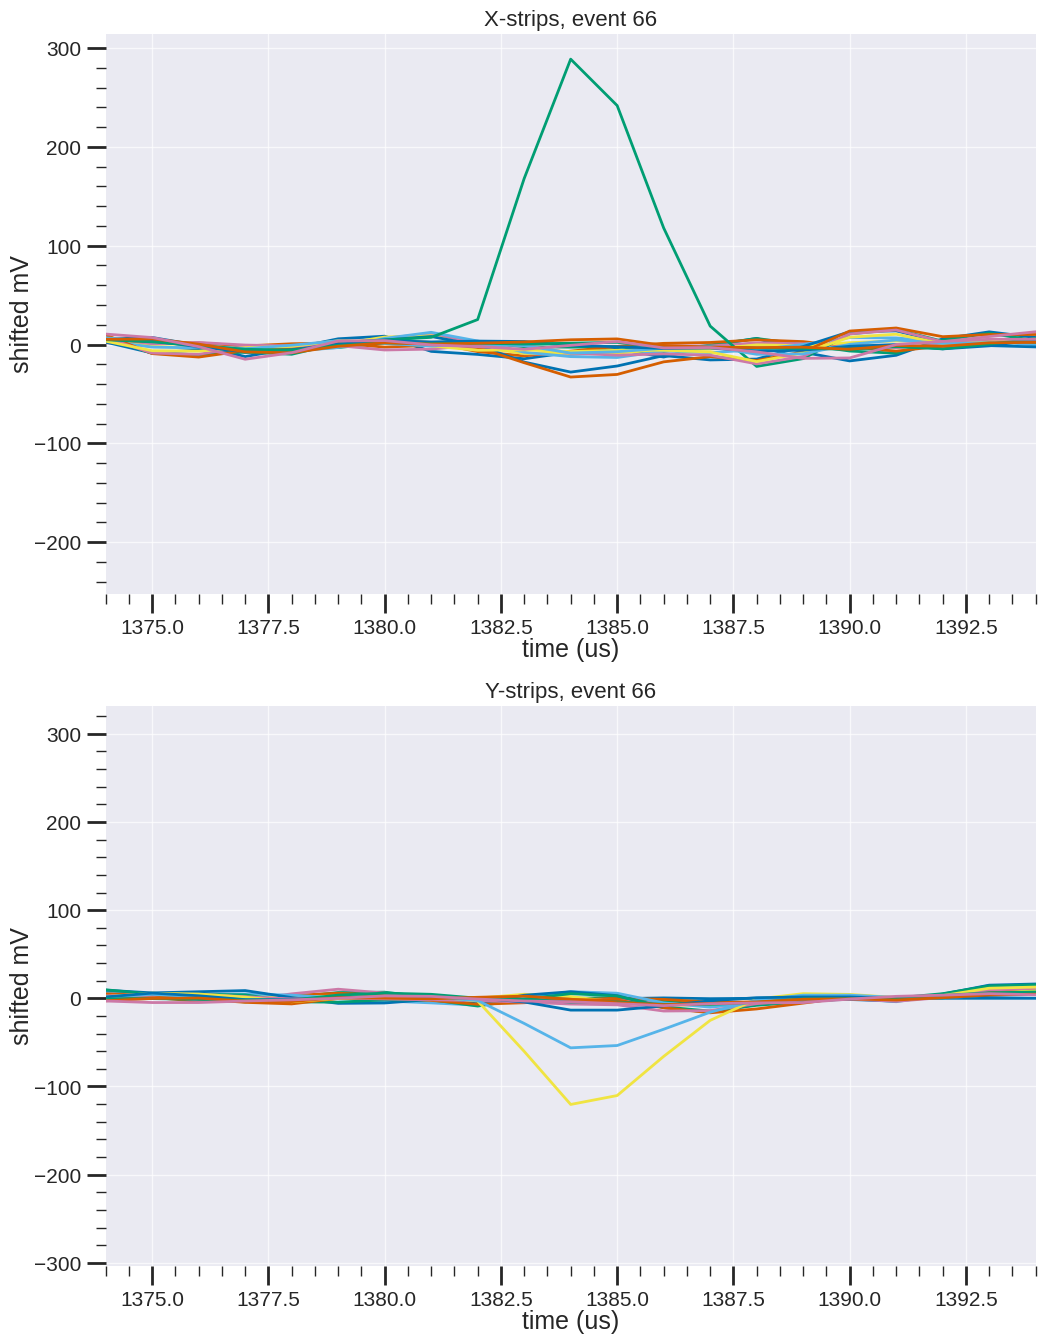

In [26]:
#some debugging validating the pulse finder is working
nevts = ca.nevents_total
total_time = nevts*2000
time_masks = [[0, 50], [980, 1050]]

outputs = {"max_amps":[], "summed_amps":[], "times":[], "max_integrals":[], "summed_integrals":[], "clustered_times":[]}

for i in range(nevts):
    if(i % 100 == 0): print(i)
    if(i > 10000): break
    all_pulses = ca.find_pulses_in_event(i, n_sigma=3)
    #random sampling of pulses
    sum_int = 0
    sum_amp = 0
    max_int = 0
    avg_time = 0 
    count = 0
    max_amp = 0
    pulse_times = []
    for pulse in all_pulses:
        if(pulse["amplitude"] < 0): continue
        mask = False
        for m in time_masks:
            if(m[0] < pulse["time"] < m[1]):
                mask = True
        
        if(mask): continue 
        ch = pulse["channel"]
        wave = ca.get_wave(i, ch)
        buffer = int(5/ca.dT) #N microseconds, in samples
        wave_range = []
        if(len(pulse["index"]) == 1):
            wave_range = [pulse["index"][0]-buffer, pulse["index"][0]+buffer]
            pulse_length = 1
        else:
            wave_range = [pulse["index"][0]-buffer, pulse["index"][-1]+buffer]
            pulse_length = pulse["index"][1] - pulse["index"][0] #samples

        if(wave_range[0] < 0): wave_range[0] = 0
        if(wave_range[1] > len(wave)): wave_range[1] = len(wave)
        if(pulse_length == 1): continue


        small_wave = wave[wave_range[0]:wave_range[1]]
        times = np.arange(len(small_wave))*ca.dT
        
        
        integ = np.trapz(small_wave, dx = ca.dT)
        if(max_int < integ):
            max_int = integ
        if(max_amp < np.max(small_wave)):
            max_amp = np.max(small_wave)
        
        sum_int += integ
        sum_amp += np.max(small_wave)
        outputs["times"].append(pulse["time"])
        pulse_times.append(pulse["time"])
        count += 1
    
    if(count == 0): continue
    
    cl = HierarchicalClustering(pulse_times, lambda x,y: abs(x-y))
    cl_means = [np.mean(cluster) for cluster in cl.getlevel(1.0)]

    if(max_amp > 500):
        fig, ax = ca.plot_strips_waveforms_separated(i, sep=0, show=False)
        ax[0].set_xlim([cl_means[0] - 10, cl_means[0] + 10])
        ax[1].set_xlim([cl_means[0] - 10, cl_means[0] + 10])
        plt.show()
        break
        
    outputs["max_amps"].append(max_amp)
    outputs["summed_amps"].append(sum_amp)
    outputs["summed_integrals"].append(sum_int)
    outputs["max_integrals"].append(max_int)
    outputs["clustered_times"].append(cl_means)
    
#pickle.dump([outputs], open("/g/g15/angelico/gamma-outputs.p", "wb"))
        


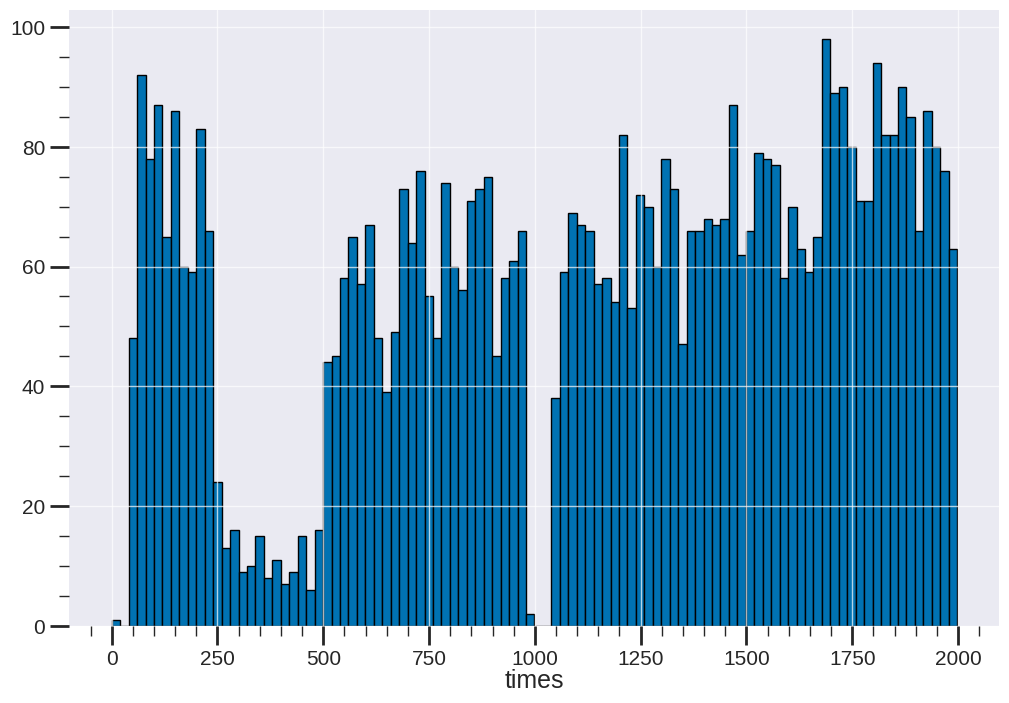

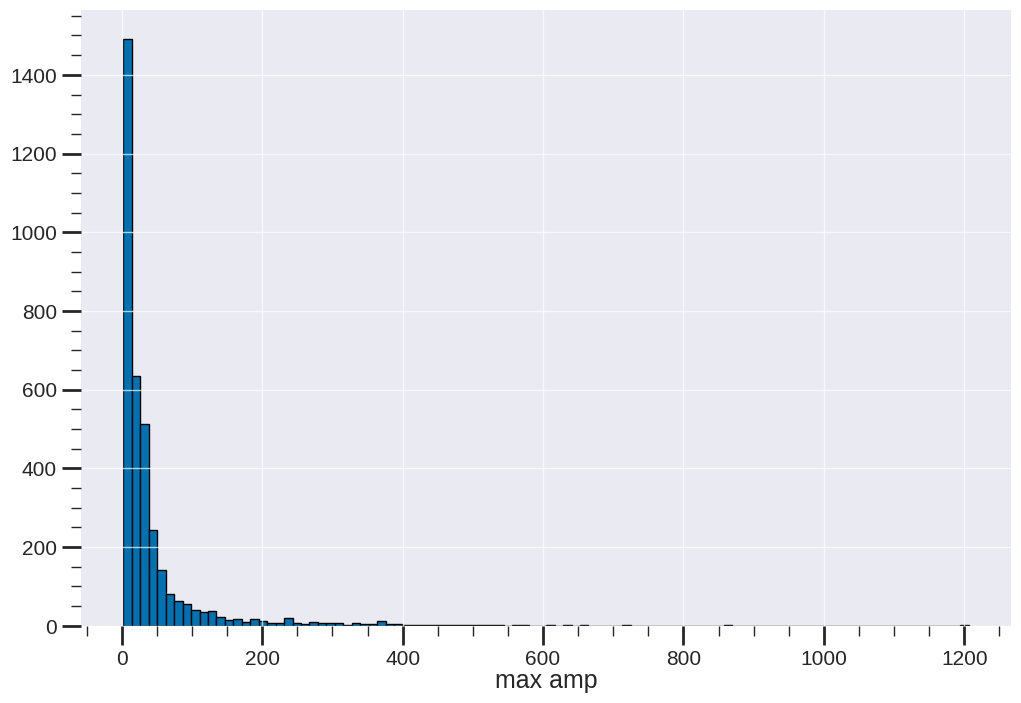

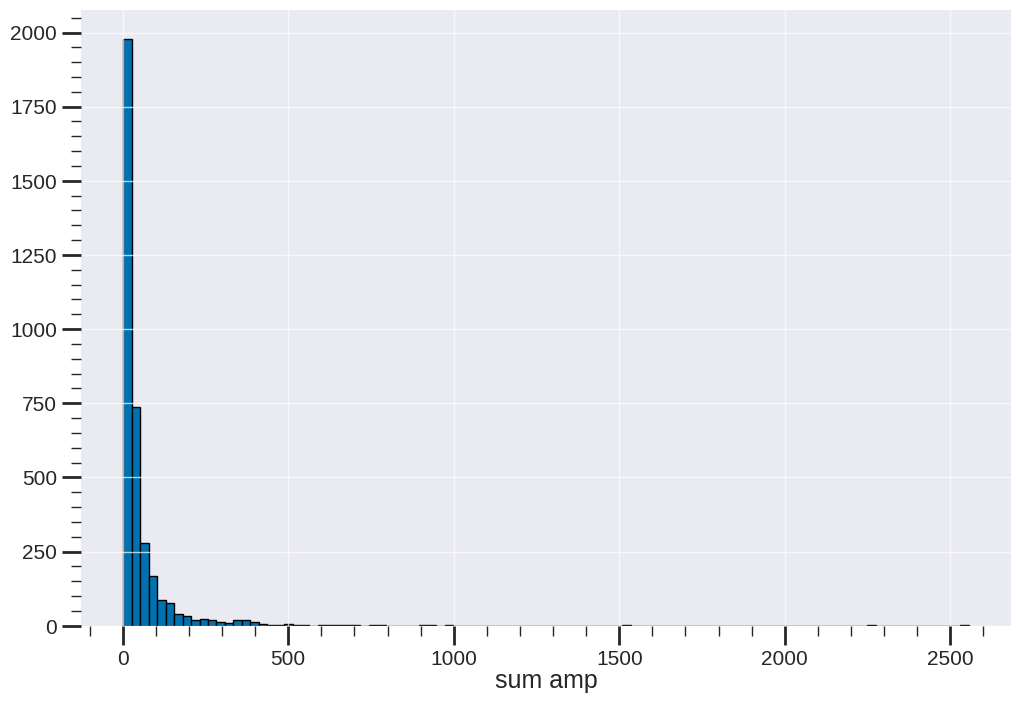

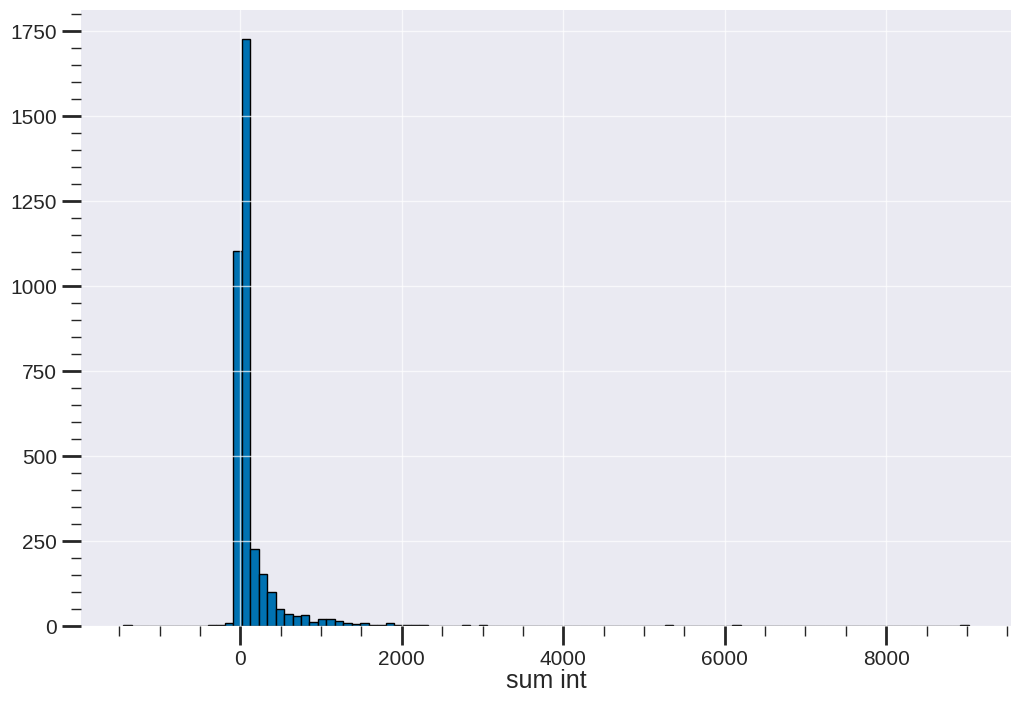

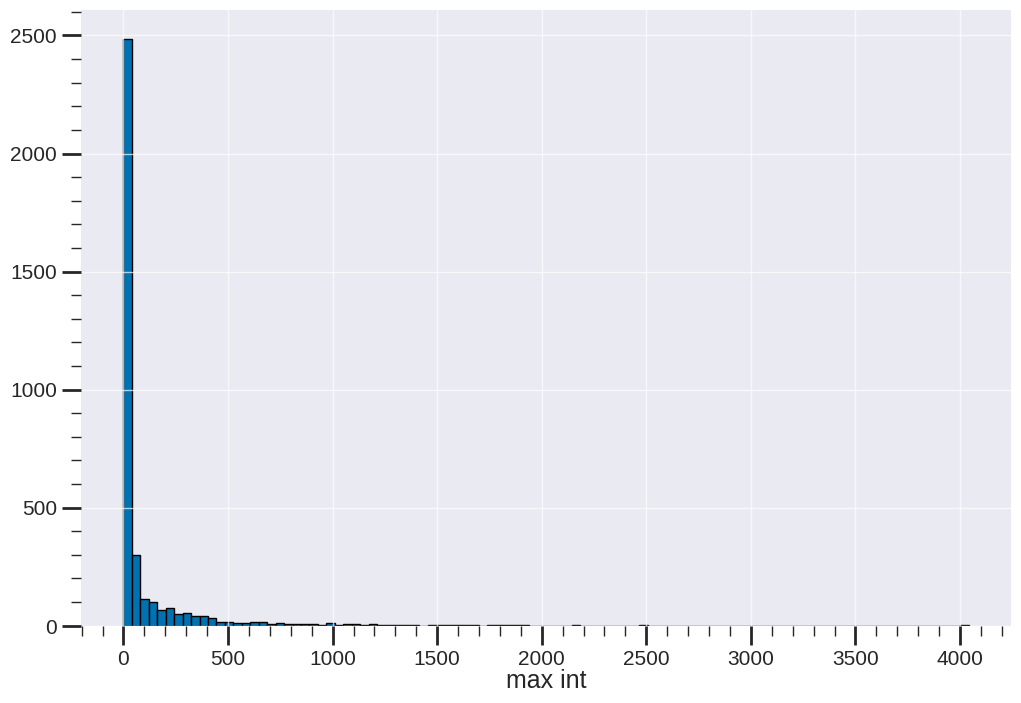

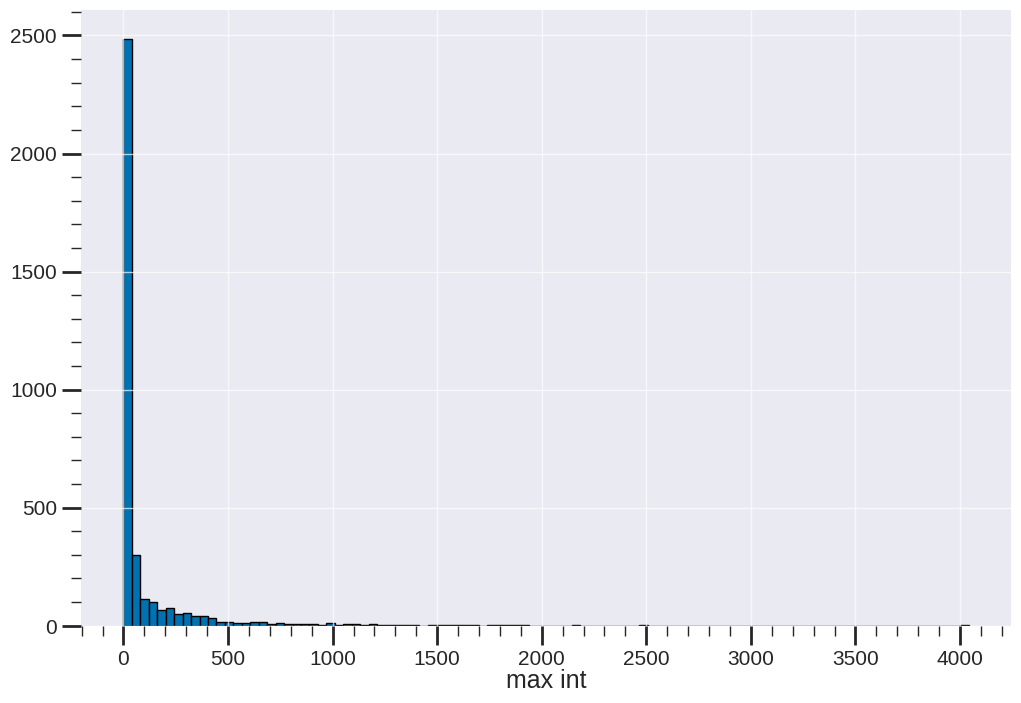

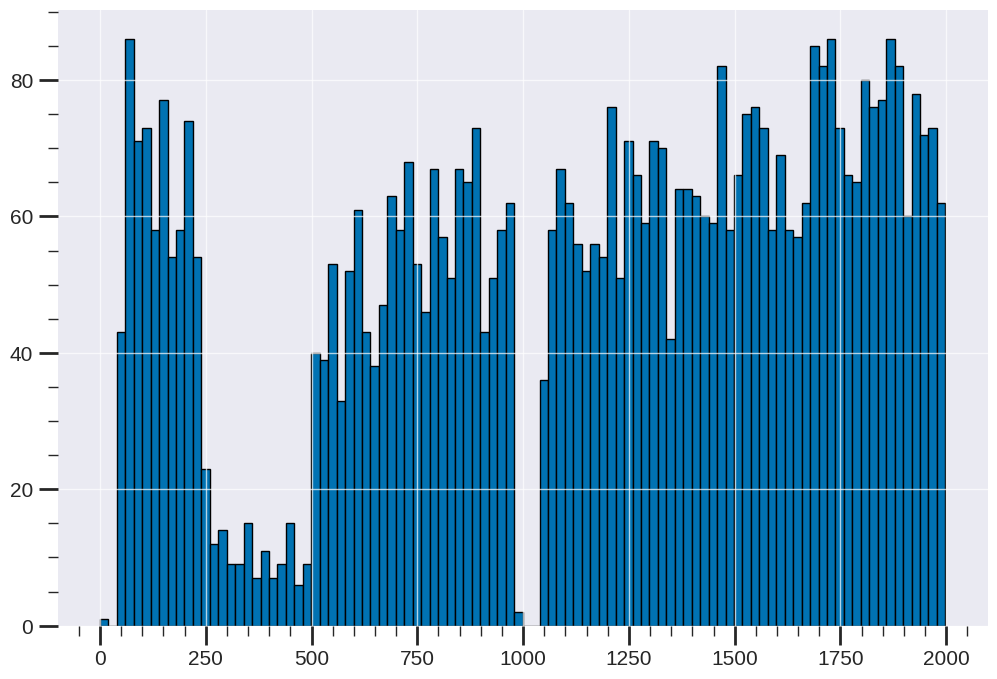

In [14]:
fig, ax = plt.subplots()
ax.hist(outputs["times"])
ax.set_xlabel("times")
plt.show()

fig, ax = plt.subplots()
ax.hist(outputs["max_amps"])
ax.set_xlabel("max amp")
plt.show()

fig, ax = plt.subplots()
ax.hist(outputs["summed_amps"])
ax.set_xlabel("sum amp")
plt.show()

fig, ax = plt.subplots()
ax.hist(outputs["summed_integrals"])
ax.set_xlabel("sum int")
plt.show()

fig, ax = plt.subplots()
ax.hist(outputs["max_integrals"])
ax.set_xlabel("max int")
plt.show()


fig, ax = plt.subplots()
ax.hist(outputs["max_integrals"])
ax.set_xlabel("max int")
plt.show()

all_clusters = []
for ct in outputs["clustered_times"]:
    all_clusters += list(ct)
    
fig, ax = plt.subplots()
ax.hist(all_clusters)
plt.show()

In [19]:
n_pulses = len(all_clusters)
print("{:d} pulses found in {:d} events for a rate of {:.2f} Hz".format(n_pulses, 10000, n_pulses/(10000*.002)))

5279 pulses found in 10000 events for a rate of 263.95 Hz
